<a href="https://colab.research.google.com/github/oyshisarker2001/Neuromarketing-Taste-Classification/blob/main/taste_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy.io
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# 1. Load your aggregated preprocessed fNIRS dataset
data = scipy.io.loadmat('All_Preprocessed_fNIRS.mat')

X = data['all_segments']       # shape (samples, time_steps, channels), e.g. (544, 1000, 16)
labels_raw = data['all_labels'].flatten()

# Convert from MATLAB cell / numpy array to list of strings if needed
labels = [str(l[0]) if (isinstance(l, np.ndarray) or isinstance(l, bytes)) else str(l) for l in labels_raw]

# 2. Encode labels to integers and then one-hot vectors
le = LabelEncoder()
y_int = le.fit_transform(labels)      # e.g. converts taste names to 0,1,2,...
y_cat = to_categorical(y_int)          # one-hot encoded labels

print(f"Classes: {le.classes_}")
print(f"Data shape: {X.shape}")
print(f"One-hot labels shape: {y_cat.shape}")

Classes: ['Bitter' 'Salty' 'Sour' 'Sweet' 'Umami']
Data shape: (544, 1000, 16)
One-hot labels shape: (544, 5)


In [ ]:

# 3. Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_int)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

# 4. Define Transformer Encoder model (your provided code)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = layers.Add()([x, inputs])

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return layers.Add()([x, res])

Training samples: 435, Validation samples: 109


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1000, 16)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1000, 16)  │         32 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1000, 16)  │     17,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1000, 16)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1000, 16)  │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1000, 16)  │         32 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1000, 128) │      2,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1000, 128) │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1000, 16)  │      2,064 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1000, 16)  │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1000, 16)  │         32 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1000, 16)  │     17,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1000, 16)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1000, 16)  │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1000, 16)  │         32 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1000, 128) │      2,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1000, 128) │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1000, 16)  │      2,064 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1000, 16)  │          0 │ conv1d_3[0][0],   │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 45,765 (178.77 KB)

 Trainable params: 45,765 (178.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 229s 16s/step - accuracy: 0.2704 - loss: 1.7244 - val_accuracy: 0.3761 - val_loss: 1.5289
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 270s 16s/step - accuracy: 0.5215 - loss: 1.4004 - val_accuracy: 0.4771 - val_loss: 1.4084
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 255s 16s/step - accuracy: 0.5780 - loss: 1.2617 - val_accuracy: 0.5872 - val_loss: 1.2482
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 262s 16s/step - accuracy: 0.6927 - loss: 1.0096 - val_accuracy: 0.5872 - val_loss: 1.0919
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 286s 17s/step - accuracy: 0.7023 - loss: 0.8798 - val_accuracy: 0.6881 - val_loss: 0.9649
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 218s 16s/step - accuracy: 0.8097 - loss: 0.7153 - val_accuracy: 0.6972 - val_loss: 0.8863
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 232s 17s/step - accuracy: 0.8338 - loss: 0.5430 - val_accuracy: 0.7615 - val_loss: 0.7862
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 269s 17s/step - accuracy: 0.8592 - loss: 0.4568 - val_accuracy: 0.

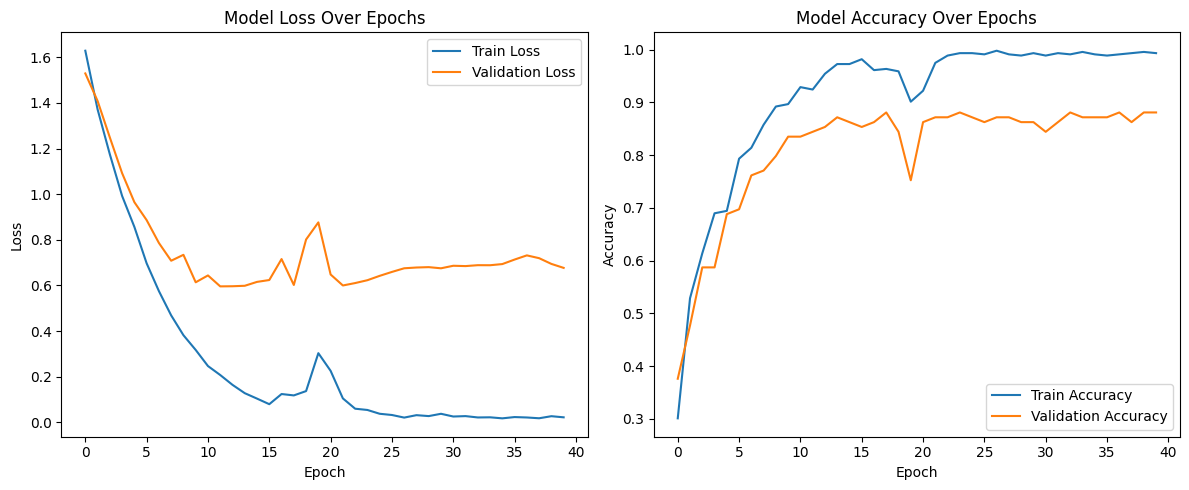

In [ ]:
def build_transformer_model(
    input_shape,
    head_size=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=2,
    mlp_units=[128],
    dropout=0.1,
    mlp_dropout=0.1,
    num_classes=5
):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for units in mlp_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# 5. Instantiate and summarize model
model = build_transformer_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    num_classes=y_cat.shape[1]
)
model.summary()

# 6. Train the model
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# 7. Plot training loss and accuracy metrics
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



Max Training Accuracy: 0.9977
Max Validation Accuracy: 0.8807
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step
Classification Report:
              precision    recall  f1-score   support

      Bitter       0.90      0.86      0.88        21
       Salty       0.90      0.86      0.88        22
        Sour       0.83      0.87      0.85        23
       Sweet       0.83      0.86      0.84        22
       Umami       0.95      0.95      0.95        21

    accuracy                           0.88       109
   macro avg       0.88      0.88      0.88       109
weighted avg       0.88      0.88      0.88       109

Confusion Matrix:
[[18  0  1  1  1]
 [ 1 19  0  2  0]
 [ 1  1 20  1  0]
 [ 0  1  2 19  0]
 [ 0  0  1  0 20]]


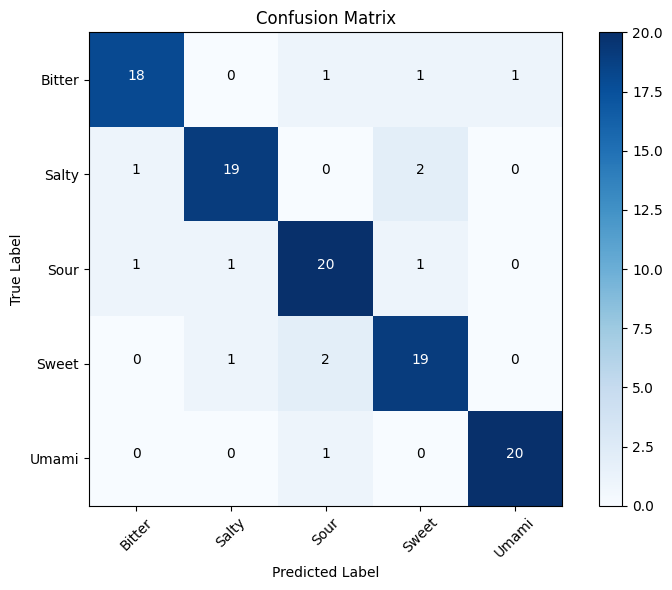

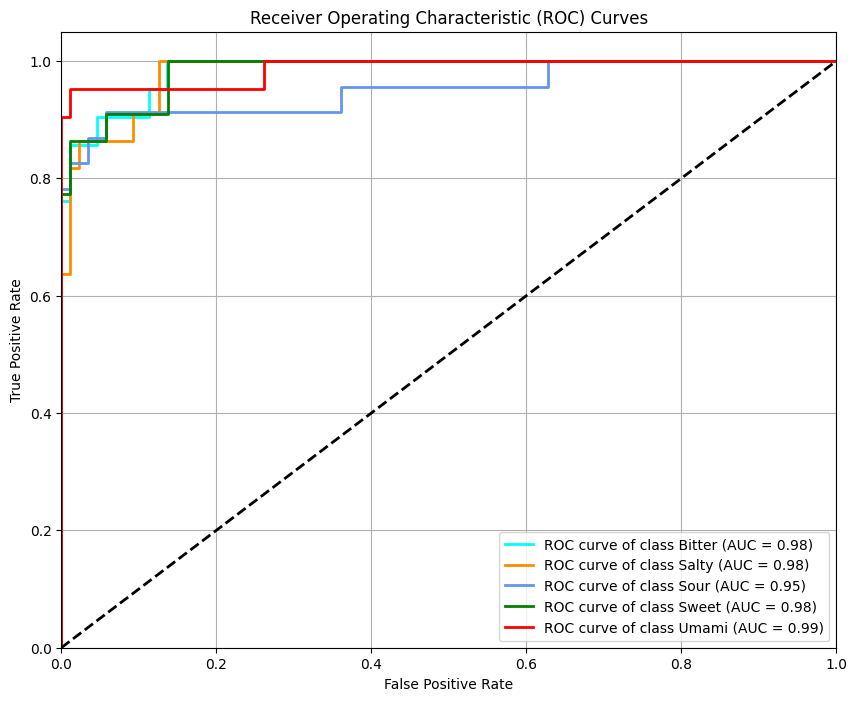

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from itertools import cycle

# 1. Print training and validation accuracy recorded during training
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print(f"Max Training Accuracy: {max(train_accuracy):.4f}")
print(f"Max Validation Accuracy: {max(val_accuracy):.4f}")

# 2. Predict class probabilities on validation set
y_pred_probs = model.predict(X_val)

# 3. Convert predicted probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# 4. Convert one-hot encoded true labels back to integer class indices
y_true = np.argmax(y_val, axis=1)

# 5. Print classification report (Precision, Recall, F1-score per class)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# 6. Compute and print confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# 7. Plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# 8. Plot ROC curves and compute AUC for each class (One-vs-Rest)
n_classes = y_val.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0,1], [0,1], 'k--', lw=2)  # diagonal line representing random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
model.save('fNIRS_transformer_model.h5')